In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_context('talk')
import matplotlib.pyplot as plt
import warnings
from SKL_search import *
warnings.filterwarnings("ignore")

In [2]:
#untie local dependency
import os
cwd = os.getcwd().split('\\')
local_repo_path = '\\'.join(cwd[:-1])
raw_data_path = local_repo_path + r'\data\raw'
processed_data_path = local_repo_path + '\data\processed'
feature_path = local_repo_path + r'\data\features'
submissions_path = local_repo_path + r'\model_submissions'

In [3]:
output_feature_fname = 'Lookback10'
sj_feature_train = pd.read_csv(feature_path + r'\\sj_train_' + output_feature_fname + '.csv', index_col=0)
sj_feature_test = pd.read_csv(feature_path + r'\\sj_test_' + output_feature_fname + '.csv', index_col=0)
iq_feature_train = pd.read_csv(feature_path + r'\\iq_train_' + output_feature_fname + '.csv', index_col=0)
iq_feature_test = pd.read_csv(feature_path + r'\\iq_test_' + output_feature_fname + '.csv', index_col=0)

In [4]:
from sklearn.svm import SVR
from sklearn import linear_model
from SKL_search import *
from sklearn.ensemble import (ExtraTreesRegressor, RandomForestRegressor, 
                              AdaBoostRegressor, GradientBoostingRegressor)

In [5]:
from sklearn.metrics import mean_absolute_error

In [6]:
sj_model, iq_model = RandomForestRegressor(n_estimators = 10000, max_depth = 20, max_features = 10), RandomForestRegressor(n_estimators = 10000, max_depth = 20, max_features = 10)
sj_model, iq_model = GradientBoostingRegressor(n_estimators = 1000, max_depth = 10, max_features = 10), GradientBoostingRegressor(n_estimators = 1000, max_depth = 10, max_features = 10)

In [7]:
def fit_and_predict(train, test, mod):
    mod.fit(train.drop(['total_cases'], axis = 1), train['total_cases'])
    test_preds = mod.predict(test.drop(['city', 'year', 'weekofyear'], axis = 1)) 
    train_preds = mod.predict(train.drop(['total_cases'], axis = 1))
    fig, ax = plt.subplots(figsize = (20,10))
    train_error = np.round(mean_absolute_error(train_preds, train['total_cases']),1)
    pd.DataFrame(train['total_cases']).reset_index(drop = True).plot(ax = ax)
    pd.DataFrame(test_preds).set_index(np.arange(len(train), len(train)+ len(test_preds))).plot(ax = ax)
    pd.DataFrame(train_preds).plot(ax = ax)
    ax.legend(labels = ['True', 'Predicted', 'Fitted'])
    ax.set_title('Mean train error: ' + str(train_error))
    return(mod, train_preds, test_preds)

In [8]:
def fit_and_predict_log(train, test, mod):
    mod.fit(train.drop('total_cases', axis = 1), np.log(1+train['total_cases']))
    test_preds = np.exp(mod.predict(test.drop(['city', 'year', 'weekofyear'], axis = 1))) -1
    train_preds = np.exp(mod.predict(train.drop('total_cases', axis = 1))) - 1
    fig, ax = plt.subplots(figsize = (20,10))
    train_error = np.round(mean_absolute_error(train_preds, train['total_cases']),1)
    pd.DataFrame(train['total_cases']).reset_index(drop = True).plot(ax = ax)
    pd.DataFrame(test_preds).set_index(np.arange(len(train), len(train)+ len(test_preds))).plot(ax = ax)
    pd.DataFrame(train_preds).plot(ax = ax)
    ax.legend(labels = ['True', 'Predicted', 'Fitted'])
    ax.set_title(str(mod).split('(')[0] + ' mean train error: ' + str(train_error))
    return(mod, train_preds, test_preds)

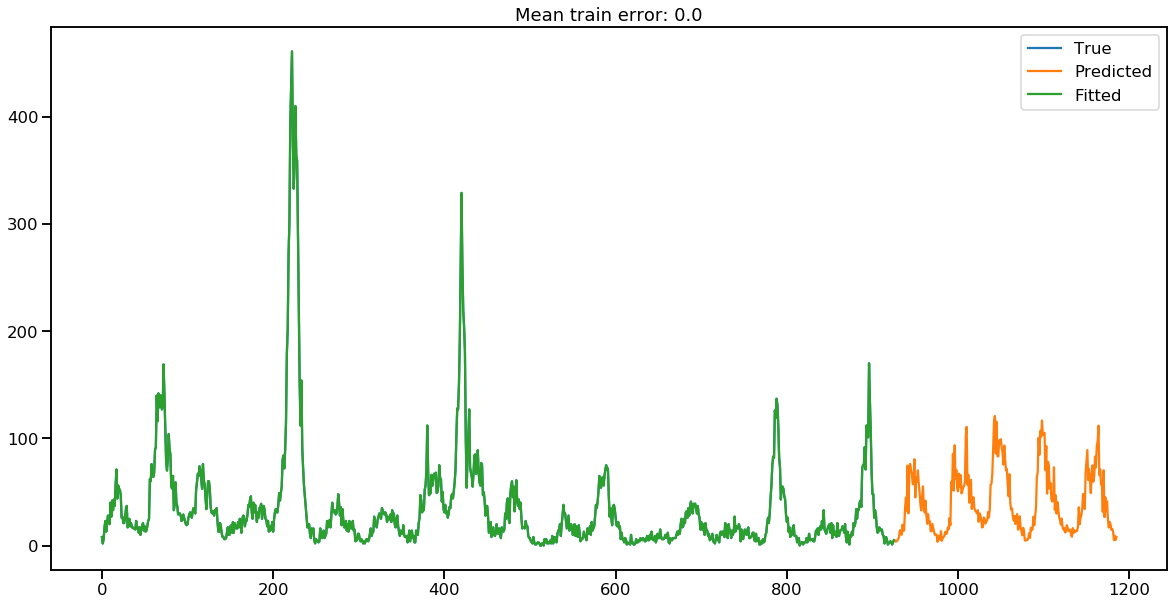

In [9]:
a, b, c = fit_and_predict(sj_feature_train, sj_feature_test, sj_model)

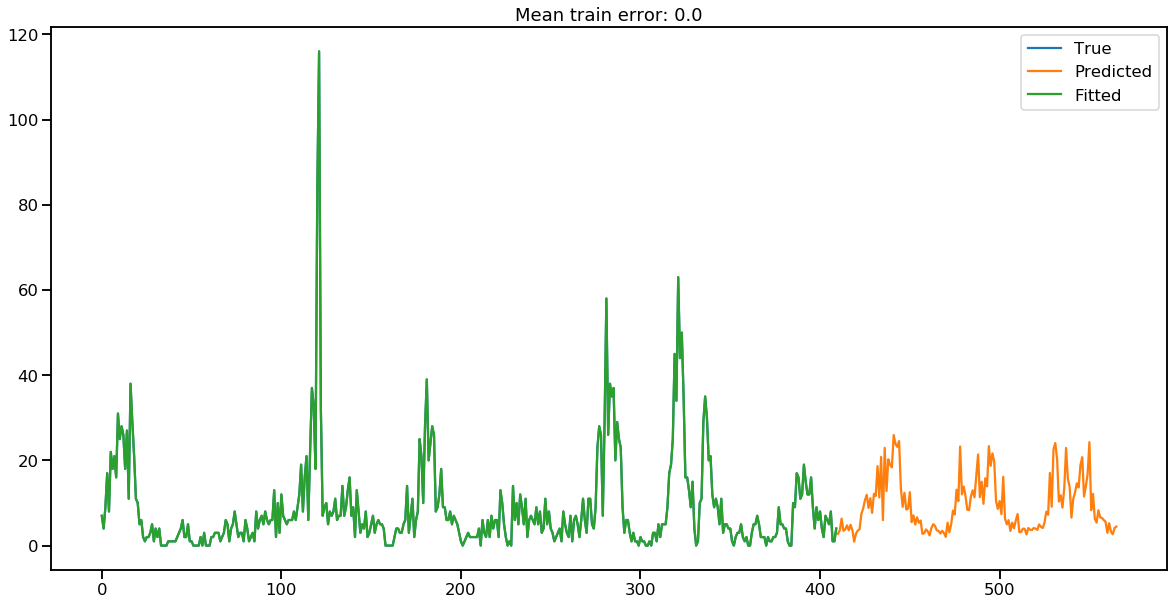

In [10]:
a, b, c = fit_and_predict(iq_feature_train.iloc[100:,:], iq_feature_test, iq_model)

In [11]:
import time 
today = time.strftime("%d-%m-%Y")

sub_fname = '\\' + str(sj_model).split('(')[0] + '_' + output_feature_fname + '_' + today + '.csv'

In [12]:
def make_submission_df(sj_train, sj_test, iq_train, iq_test, sj_mod, iq_mod):
    sj_mod.fit(sj_train.drop('total_cases', axis = 1), sj_train['total_cases'])
    sj_preds = sj_mod.predict(sj_test.drop(['city', 'year', 'weekofyear'], axis = 1))
    sj_sub = pd.DataFrame(sj_test[['city', 'year', 'weekofyear']])
    sj_sub['total_cases'] = np.round(sj_preds).astype(int)
    
    iq_mod.fit(iq_train.drop('total_cases', axis = 1), iq_train['total_cases'])
    iq_preds = iq_mod.predict(iq_test.drop(['city', 'year', 'weekofyear'], axis = 1))
    iq_sub = pd.DataFrame(iq_test[['city', 'year', 'weekofyear']])
    iq_sub['total_cases'] = np.round(iq_preds).astype(int)
    
    final_sub = sj_sub.append(iq_sub)
    final_sub['year'] = final_sub['year'].astype(int)
    final_sub['weekofyear'] = final_sub['weekofyear'].astype(int)
                              
    return(final_sub)

In [13]:
sub = make_submission_df(sj_feature_train, sj_feature_test, iq_feature_train, iq_feature_test, sj_model, iq_model)

In [14]:
sub

city  year  weekofyear  total_cases
0     sj  2008          18            3
1     sj  2008          19            5
2     sj  2008          20            3
3     sj  2008          21            6
4     sj  2008          22            6
..   ...   ...         ...          ...
151   iq  2013          22            4
152   iq  2013          23            5
153   iq  2013          24            5
154   iq  2013          25            4
155   iq  2013          26            5

[416 rows x 4 columns]

In [15]:
sub.to_csv(submissions_path + sub_fname, index = False)